# Global Spatial Autocorrelation

Spatial autocorrelation is the degree to which a variable is correlated with itself across space. It is a measure of how things are related to each other based on their locations. It is a key concept in spatial statistics and has many applications in spatial data analysis. 

A lot of this notebook is borrowed almost directly from [this](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) notebook (just adapted to cell/nuclei/tissue segmentation domain) including the following descriptions of spatial autocorrelation. So please check it out for more details. It is very good.

> "*Spatial autocorrelation measures the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations.* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)"

> "*A key idea in this context is that of spatial randomness: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if its distribution follows no discernible spatial pattern. Spatial autocorrelation can thus be defined as the “absence of spatial randomness”.*" - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)"

> "*Spatial autocorrelation is typically categorized along two main dimensions: sign and scale. Similar to the traditional, non-spatial case, spatial autocorrelation can adopt two main forms: positive and negative. The former relates to a situation where similarity and geographical closeness go hand-in-hand. In other words, similar values are located near each other, while different values tend to be scattered and further away. It is important that the sign of these values is not relevant for the presence of spatial autocorrelation: it may be high values close to high values, or low values close to low values. The important bit in this context is the relationship between closeness and statistical similarity is positive.*" - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)"

In this notebook, we will be using the [Global Moran's I](https://en.wikipedia.org/wiki/Moran%27s_I) statistic and the infamous Moran scatter plot to measure spatial autocorrelation. We are especially interested, whether the immune cells appear in each others cell neighborhoods, thus, showing spatial autocorrelation. In other words, we want to basically see whether there is some sort of global trend of immune cell clustering. 

## The Data

Like in the [Spatial Grids](https://okunator.github.io/cellseg_gsontools/user_guide/spatial_grids/) example, the data used in this example is a cervical pre-cancerous biopsy. The data is not publicly available, so this serves only as a demonstration of the functionality `cellseg_gsontools`.

In [1]:
from pathlib import Path
from cellseg_gsontools import read_gdf

tissue_path = Path("/path/to/tissues.geojson")
nuc_path = Path("/path/to/nuclei.geojson")

tissues = read_gdf(tissue_path)[["geometry", "class_name"]] # take only relevant columns
nuclei = read_gdf(nuc_path)[["geometry", "class_name"]]

tissues.head(5)

,geometry,class_name
0,"POLYGON ((8726.00000 101404.00000, 8721.71000 ...",area_cin
1,"POLYGON ((8098.00000 102263.00000, 8095.19000 ...",area_cin
2,"POLYGON ((17873.00000 115644.00000, 17870.5200...",areastroma
3,"POLYGON ((16787.00000 100733.00000, 16773.7100...",areastroma
4,"POLYGON ((16387.00000 96785.00000, 16384.19000...",areastroma


In [2]:
nuclei.head(5)

,geometry,class_name
0,"POLYGON ((6679.00000 103882.02000, 6677.01000 ...",neoplastic
1,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic
2,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective
3,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective
4,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective


<Axes: >

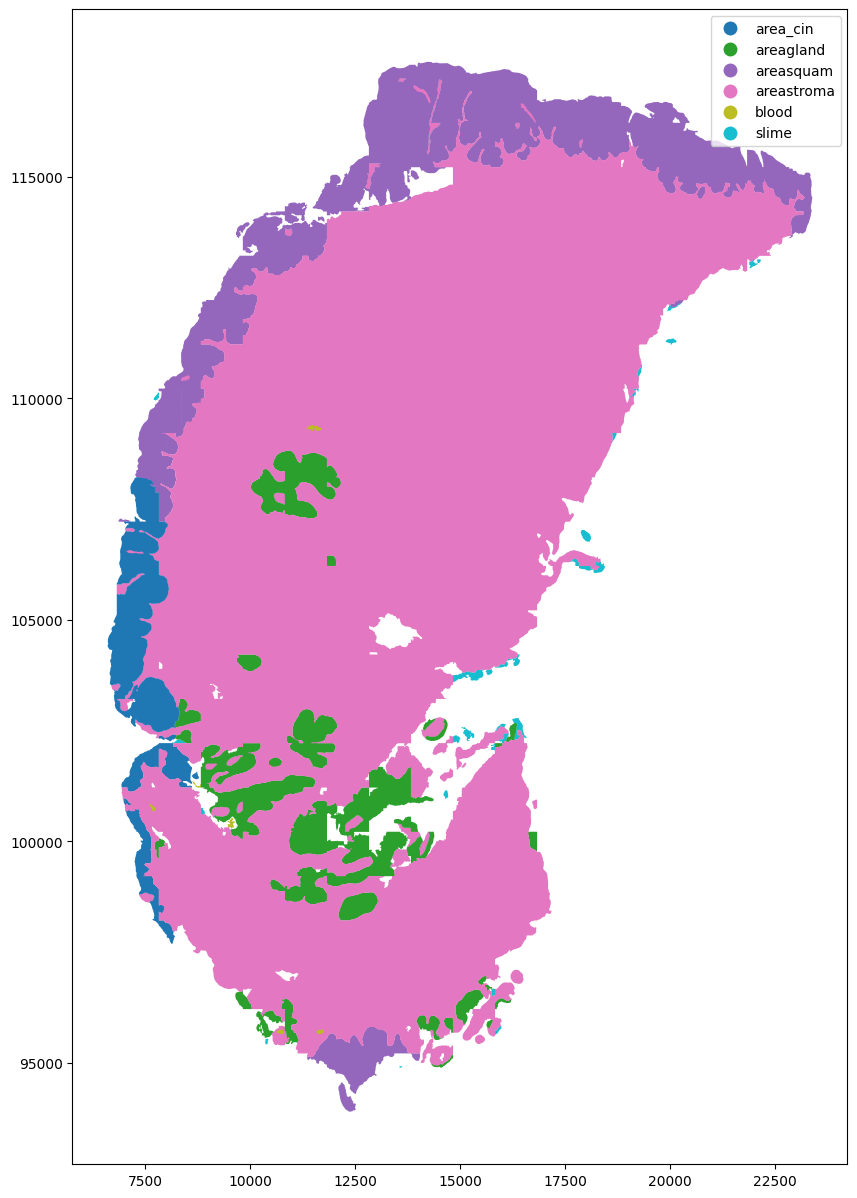

In [3]:
tissues.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

<Axes: >

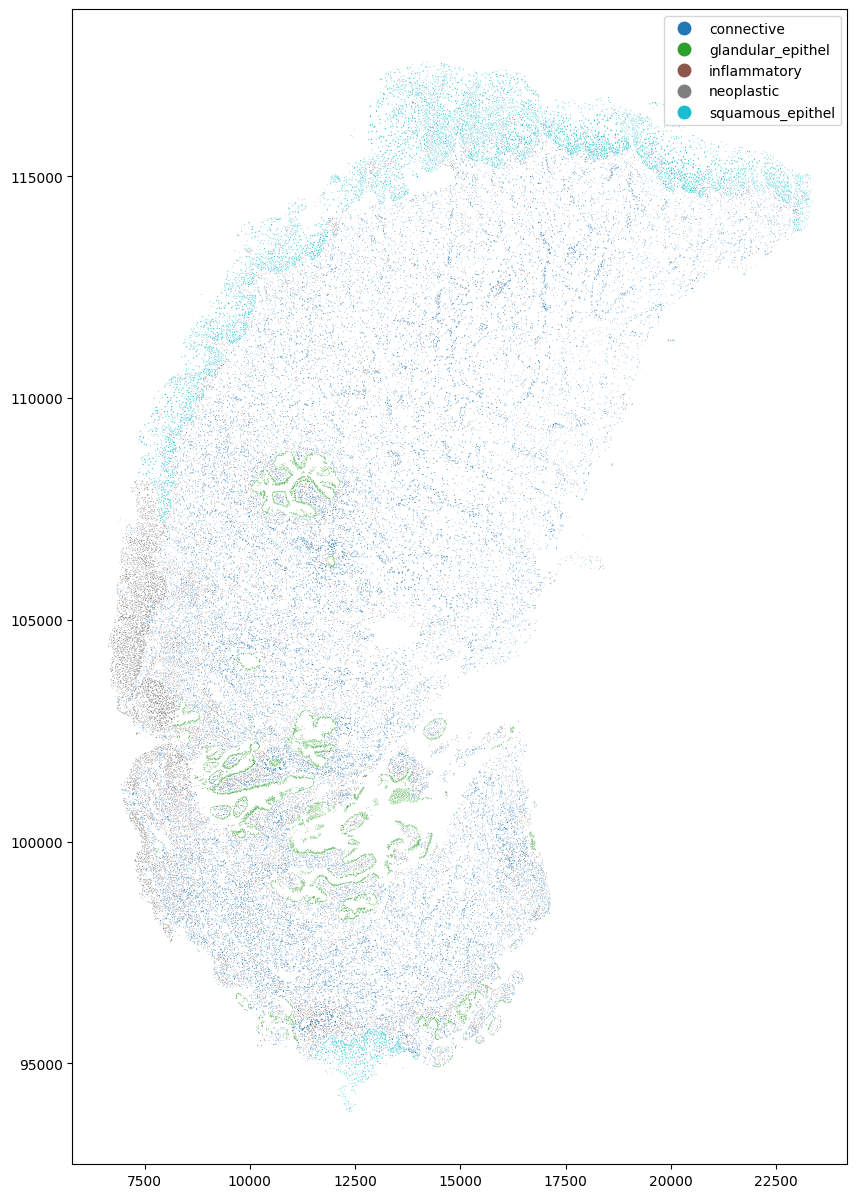

In [4]:
nuclei.plot(figsize=(10, 15), column="class_name", legend=True, aspect=None)

## Filtering the Cells in the Stroma

In this example, we will be looking at the spatial autocorrelation of cells within the stroma. Thus, we will filter only the cells within the stroma from the data.

In [5]:
stromaltissue = tissues.loc[tissues["class_name"] == "areastroma"]
stromaltissue.head(4)

,geometry,class_name
2,"POLYGON ((17873.00000 115644.00000, 17870.5200...",areastroma
3,"POLYGON ((16787.00000 100733.00000, 16773.7100...",areastroma
4,"POLYGON ((16387.00000 96785.00000, 16384.19000...",areastroma
5,"POLYGON ((16365.00000 116080.00000, 16360.9800...",areastroma


In [6]:
from cellseg_gsontools.utils import set_uid

stromalnuclei = nuclei.sjoin(stromaltissue, how="inner", predicate="within")

# we will set a new indexing for the filtered cells for the contiguity graph
# that is fitted next.
stromalnuclei = set_uid(stromalnuclei, id_col="uid", drop=False)

# take only relevant columns
stromalnuclei = stromalnuclei.loc[:, ["geometry", "class_name_left", "uid"]]
stromalnuclei.rename(columns={"class_name_left": "class_name"}, inplace=True)
stromalnuclei

,geometry,class_name,uid
uid,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4
...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607


<Axes: >

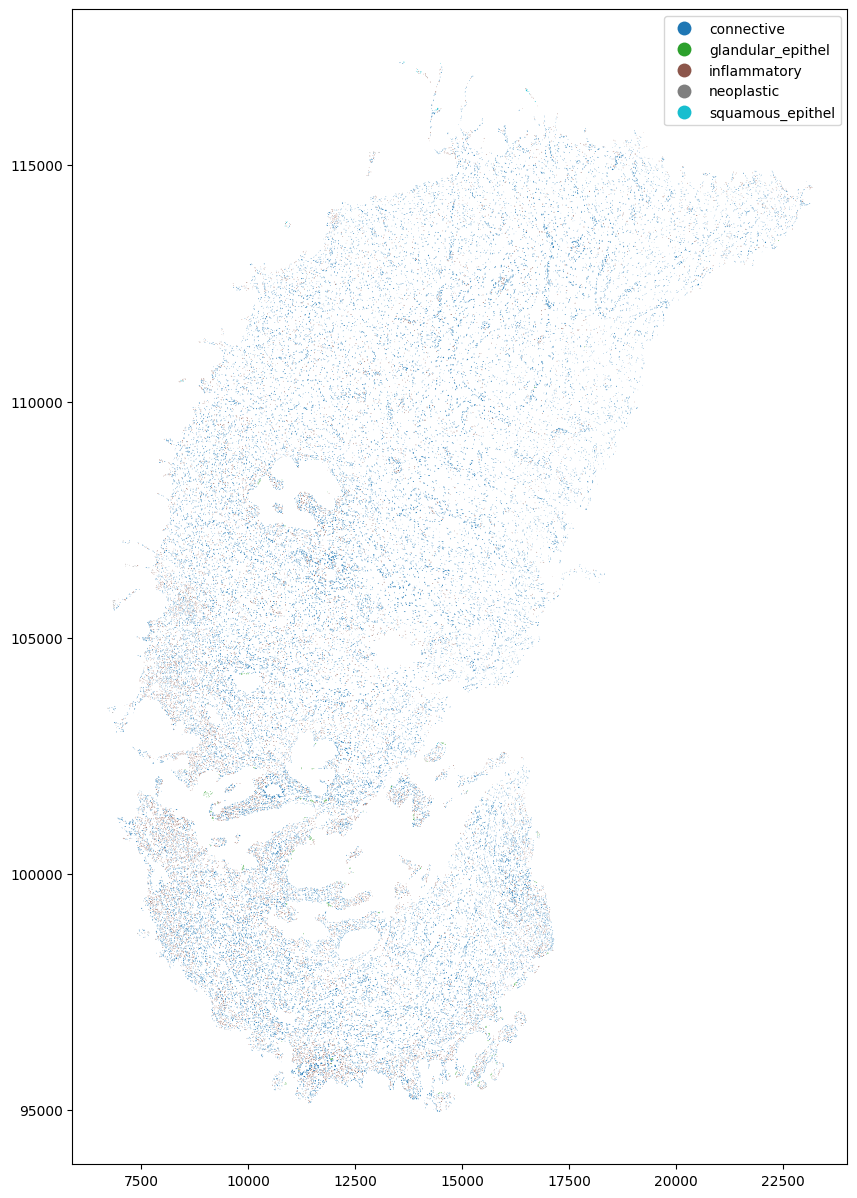

In [7]:
stromalnuclei.plot(
    figsize=(10, 15),
    column="class_name",
    legend=True,
    aspect=None,
)

## Spatial Weights

Next, we will fit a contiguity grpah on the cells, to extract the neighborhoods of each cell. We will use the `distband` contiguity graph, that connects each cell to all cells within a certain distance. We will use a distance of 50 microns (100 pixels since the segmentation was run done 20x magnification).

In [8]:
from cellseg_gsontools.graphs import fit_graph

w = fit_graph(
    stromalnuclei,
    type="distband",
    id_col="uid",
    thresh=100,
)

# Non-standardized weights
w.transform = "R"
w

## Neighborhood Immune Index

Since we are interested in the global spatial autocorrelation of immune cell localization, we will calculate the count and fraction of the immune cells in each cell neighborhood. We will use these features to calculate an immune index (immune fraction $\times$ immune count) that we will use as the feature for the global autocorrelation analysis. The reason to use the immune index instead of the immune fraction is that the immune fraction will give high values for neihgborhoods with 1/1 or 2/2 immune cells which is are not very indicative of the actual clustering of immune cells whereas neighborhood of 9/9 immune cells would be indicative of clustering.

In [9]:
from cellseg_gsontools.apply import gdf_apply
from cellseg_gsontools.neighbors import neighborhood, nhood_vals, nhood_type_count
from functools import partial

# Get the neihgboring nodes of the graph
func = partial(neighborhood, spatial_weights=w)
stromalnuclei["nhood"] = gdf_apply(stromalnuclei, func, columns=["uid"])

# Get the classes of the neighboring nodes
func = partial(nhood_vals, values=stromalnuclei["class_name"])
stromalnuclei["nhood_classes"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood"],
)

# Get the number of inflammatory cells in the neighborhood
func = partial(nhood_type_count, cls="inflammatory", frac=False)
stromalnuclei["immune_cnt"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood_classes"],
)

# Get the fraction of inflammatory cells in the neighborhood
func = partial(nhood_type_count, cls="inflammatory", frac=True)
stromalnuclei["immune_frac"] = gdf_apply(
    stromalnuclei,
    func=func,
    parallel=True,
    columns=["nhood_classes"],
)

# This will smooth the extremes (e.g. if there is only one inflammatory cell in the 
# neighborhood, the fraction will be 1)
stromalnuclei["immune_index"] = stromalnuclei["immune_frac"] * stromalnuclei["immune_cnt"]

stromalnuclei

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index
uid,,,,,,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0,"[0, 1, 2, 3]","[neoplastic, connective, connective, connective]",0.0,0.000000,0.000000
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1,"[1, 0, 2, 3, 4]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2,"[2, 0, 1, 3, 4, 5, 6, 7]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3,"[3, 0, 1, 2, 8]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4,"[4, 1, 2, 5, 6, 7, 8]","[connective, connective, connective, connectiv...",0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605,"[45605, 45602, 45604, 45607, 45608, 45609]","[neoplastic, neoplastic, neoplastic, neoplasti...",1.0,0.166667,0.166667
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606,"[45606, 45601, 45602, 45603]","[neoplastic, inflammatory, neoplastic, neoplas...",1.0,0.250000,0.250000
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607,"[45607, 45604, 45605, 45608, 45609]","[neoplastic, neoplastic, neoplastic, inflammat...",1.0,0.200000,0.200000


## Spatial Lag

To compute the Global Moran's I statistic, the spatial lag of a variable is needed. This applies also to the Moran plot. Our variables of interest is the immune index.

> "*The spatial lag operator is one of the most common and direct applications of spatial weights matrices (called formally) in spatial analysis. The mathematical definition is the product of and the vector of a given variable. Conceptually, the spatial lag captures the behavior of a variable in the immediate surroundings of each location; in that respect, it is akin to a local smoother of a variable.*" - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)"

In [10]:
from libpysal.weights import lag_spatial

stromalnuclei["immune_index_lag"] = lag_spatial(w, stromalnuclei["immune_index"].values)
stromalnuclei["immune_index_lag"]

uid
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
45605    0.160000
45606    0.194444
45607    0.191667
45608    0.191667
45609    0.191667
Name: immune_index_lag, Length: 45610, dtype: float64

## Moran Plot and Moran's I
Next we will plot the so called Moran scatter plot after which we will compute the Moran's I statistic for the immune index. The Moran's I statistic is a measure of spatial autocorrelation based on attribute similarity. Here, it is a measure of how similar the immune index values are to its spatial lag values.  

### The Moran Plot

> *The Moran plot is a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, the variable of interest is usually standardized by subtracting its mean.* - [Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)

In [11]:
# Standardize the immune_fraction column
stromalnuclei["immune_index_normed"] = (
    stromalnuclei["immune_index"] - stromalnuclei["immune_index"].mean()
)

# Display the updated dataframe
stromalnuclei

,geometry,class_name,uid,nhood,nhood_classes,immune_cnt,immune_frac,immune_index,immune_index_lag,immune_index_normed
uid,,,,,,,,,,
0,"POLYGON ((6726.00000 103493.02000, 6724.01000 ...",neoplastic,0,"[0, 1, 2, 3]","[neoplastic, connective, connective, connective]",0.0,0.000000,0.000000,0.000000,-1.550176
1,"POLYGON ((6755.01000 103504.01000, 6755.01000 ...",connective,1,"[1, 0, 2, 3, 4]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,0.000000,-1.550176
2,"POLYGON ((6823.99000 103510.01000, 6823.00000 ...",connective,2,"[2, 0, 1, 3, 4, 5, 6, 7]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,0.000000,-1.550176
3,"POLYGON ((6760.00000 103443.02000, 6758.01000 ...",connective,3,"[3, 0, 1, 2, 8]","[connective, neoplastic, connective, connectiv...",0.0,0.000000,0.000000,0.000000,-1.550176
4,"POLYGON ((6848.01000 103481.02000, 6845.01000 ...",connective,4,"[4, 1, 2, 5, 6, 7, 8]","[connective, connective, connective, connectiv...",0.0,0.000000,0.000000,0.000000,-1.550176
...,...,...,...,...,...,...,...,...,...,...
45605,"POLYGON ((7217.01000 106533.02000, 7215.01000 ...",neoplastic,45605,"[45605, 45602, 45604, 45607, 45608, 45609]","[neoplastic, neoplastic, neoplastic, neoplasti...",1.0,0.166667,0.166667,0.160000,-1.383510
45606,"POLYGON ((7390.00000 106510.02000, 7387.01000 ...",neoplastic,45606,"[45606, 45601, 45602, 45603]","[neoplastic, inflammatory, neoplastic, neoplas...",1.0,0.250000,0.250000,0.194444,-1.300176
45607,"POLYGON ((7133.75000 106514.00000, 7129.01000 ...",neoplastic,45607,"[45607, 45604, 45605, 45608, 45609]","[neoplastic, neoplastic, neoplastic, inflammat...",1.0,0.200000,0.200000,0.191667,-1.350176


Let's plot!

Text(0.5, 1.0, 'Moran Plot - Immune Cell Index')

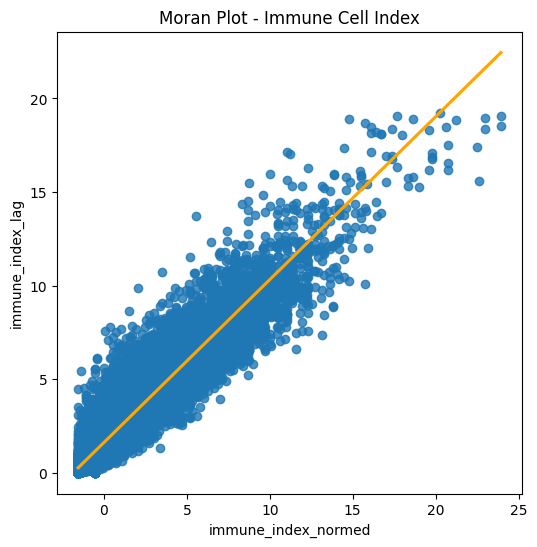

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    ax=ax,
    x="immune_index_normed",
    y="immune_index_lag",
    ci=None,
    data=stromalnuclei,
    line_kws={"color": "orange"},
)

ax.set_title("Moran Plot - Immune Cell Index")

From the plot above, we can see that the immune cell index is positively correlated with its spatial lag. This means that cells with high immune cell index tend to be surrounded by cells with high immune cell index and low immune index cells are surrounded by low other low immune index cells. This is an indication of positive spatial autocorrelation. The main pattern of this data seems to be that similar immune index values tend to be located close to each other.

### Moran's I Statistic

To compute the Moran's I statistic, we will use the `esda` package.

> "*Moran’s I captures much of the essence of the Moran Plot. In fact, there is a close connection between the two: the value of Moran’s I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.*"

In [13]:
# !pip install esda

In [14]:
import esda

moran = esda.Moran(stromalnuclei["immune_index"], w)

In [15]:
moran.I

0.8723745127666674

The obtained Moran's I statistic tells us that there is a positive spatial autocorrelation in the immune cell index

In [16]:
moran.p_sim

0.001

P-values for accepting/rejecting the hypothesis that the variable (immune index) is randomly distributed spatially across the cells. This p-value is computed over 999 simulations of spatially randomly distributed variable immune indices, thus, the oddly specific p-value. From these results, we can conclude that the cells in the stroma displays more spatial pattern than we would expect if the immune index of the cells had been randomly allocated to random locations.

## Plotting the Immune Cell Index

Lastly, let's visualize the immune cell fraction and immune cell count on the tissue to see whether the immune cells tend to form spatial clusters and localize nearby each other.

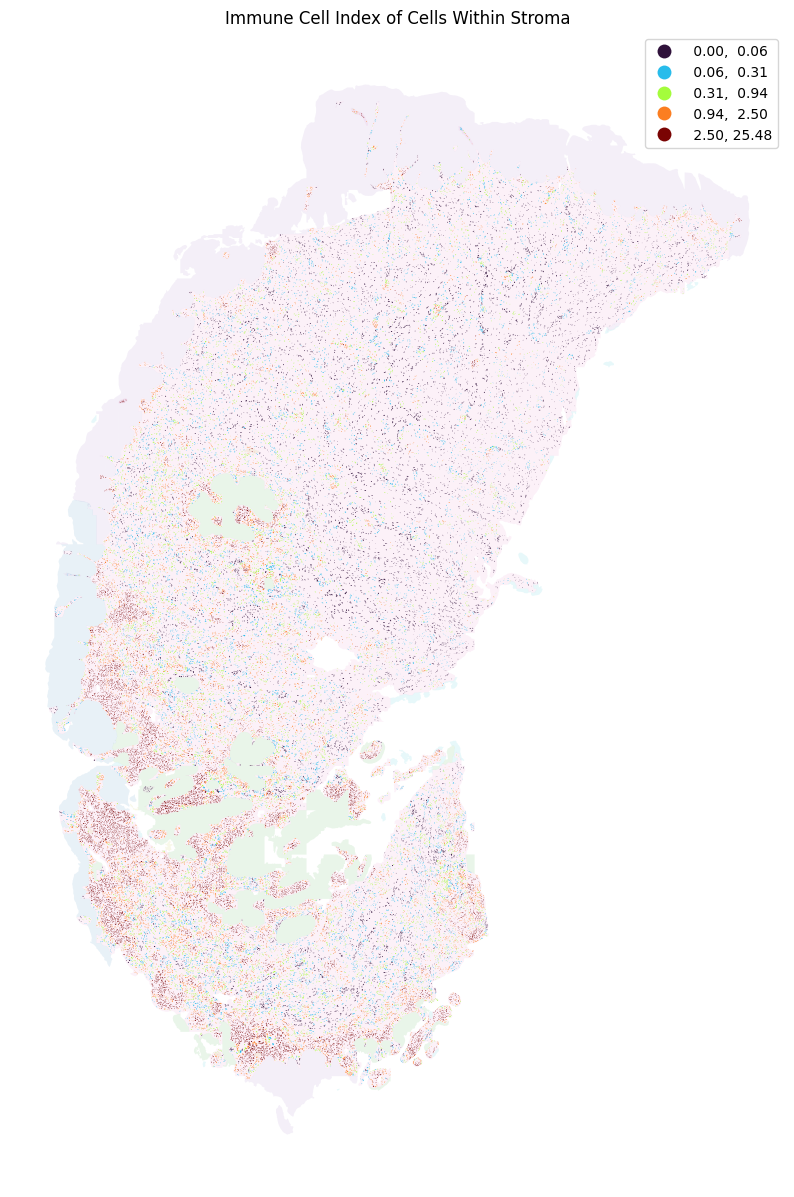

In [17]:
ax = tissues.plot(
    figsize=(10, 15),
    column="class_name",
    alpha=0.1,
    legend=True,
    aspect=None,
)

ax = stromalnuclei.plot(
    ax=ax,
    column="immune_index",
    legend=True,
    aspect=None,
    scheme="Quantiles",
    cmap="turbo"
)

ax.set_title("Immune Cell Index of Cells Within Stroma")
ax.set_axis_off()

Just by eyeballing the plot, it's quite obvious that the cells with high immune cell index tend to cluster together. These can be seen as the red 'hotspots' in the plot. This is also supported by the Moran's I statistic and Moran plot. Another thing to notice here, is that the hotspots localize close to the pre-cancerous lesions - an indication of immune infiltration. We will dig into this in more detail in the next notebook.